In [ ]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [128]:
dataset= pd.read_csv("/content/flightdata.csv")
dataset.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [129]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [130]:
dataset = dataset.drop('Unnamed: 25', axis=1)
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [131]:
#filter the dataset to climinate columns that aren't relevant to a predictive model_
dataset = dataset[["FL_NUM", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME", "DEP_DEL15", "ARR_DEL15"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DEL15       107
ARR_DEL15       188
dtype: int64

In [132]:
dataset[dataset.isnull().any(axis=1)].head(10)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,NaN
179,86,1,10,7,MSP,DTW,1632,NaN,NaN
184,557,1,10,7,MSP,DTW,912,0.0,NaN
210,1096,1,10,7,DTW,MSP,1303,NaN,NaN
478,1542,1,22,5,SEA,JFK,723,NaN,NaN
481,1795,1,22,5,ATL,JFK,2014,NaN,NaN
491,2312,1,22,5,MSP,JFK,2149,NaN,NaN
499,423,1,23,6,JFK,ATL,1600,NaN,NaN
500,425,1,23,6,JFK,ATL,1827,NaN,NaN
501,427,1,23,6,JFK,SEA,1053,NaN,NaN


In [133]:
dataset['DEP_DEL15'].mode()

0    0.0
Name: DEP_DEL15, dtype: float64

In [134]:
#replace the missing values with is.
dataset = dataset.fillna({'ARR_DEL15': 1})
dataset = dataset.fillna({'DEP_DEL15': 0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,1.0
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,1.0
180,87,1,10,7,DTW,MSP,1649,1.0,0.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0
184,557,1,10,7,MSP,DTW,912,0.0,1.0


In [135]:
import math

for index, row in dataset.iterrows():
    dataset.loc[index, 'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,ATL,SEA,21,0.0,0.0
1,1476,1,1,5,DTW,MSP,14,0.0,0.0
2,1597,1,1,5,ATL,SEA,12,0.0,0.0
3,1768,1,1,5,SEA,MSP,13,0.0,0.0
4,1823,1,1,5,SEA,DTW,6,0.0,0.0


In [136]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['DEST'] = le.fit_transform(dataset['DEST'])
dataset['ORIGIN'] = le.fit_transform(dataset['ORIGIN'])

In [137]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,0,4,21,0.0,0.0
1,1476,1,1,5,1,3,14,0.0,0.0
2,1597,1,1,5,0,4,12,0.0,0.0
3,1768,1,1,5,4,3,13,0.0,0.0
4,1823,1,1,5,4,1,6,0.0,0.0


In [138]:
dataset['ORIGIN'].unique()

array([0, 1, 4, 3, 2])

In [15]:
dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,0,0.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,0,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,0,0.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,0,0.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,0,0.0,0.0,0,0,0,0,1,0,1,0,0,0


In [26]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [27]:
x

array([[1.399e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.476e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.597e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.823e+03, 1.200e+01, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.901e+03, 1.200e+01, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.005e+03, 1.200e+01, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [28]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()
#x=np.delete(x,[4,7],axis=1)

In [29]:
z

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [30]:
t

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [31]:
x=np.delete(x,[4,5],axis=1)

In [32]:
import seaborn as sns
%matplotlib inline


In [33]:
flight_data =pd.read_csv("/content/flightdata.csv")

In [34]:

flight_data.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
count,11231.0,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11124.000000,...,11231.000000,11116.000000,11043.000000,11043.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000,0.0
mean,2016.0,2.544475,6.628973,15.790758,3.960199,1334.325617,12334.516695,12302.274508,1320.798326,1327.189410,...,1537.312795,1523.978499,-2.573123,0.124513,0.010150,0.006589,190.652124,179.661233,1161.031965,NaN
std,0.0,1.090701,3.354678,8.782056,1.995257,811.875227,1595.026510,1601.988550,490.737845,500.306462,...,502.512494,512.536041,39.232521,0.330181,0.100241,0.080908,78.386317,77.940399,643.683379,NaN
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,2.000000,1.000000,-67.000000,0.000000,0.000000,0.000000,93.000000,75.000000,509.000000,NaN
25%,2016.0,2.000000,4.000000,8.000000,2.000000,624.000000,10397.000000,10397.000000,905.000000,905.000000,...,1130.000000,1135.000000,-19.000000,0.000000,0.000000,0.000000,127.000000,117.000000,594.000000,NaN
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1267.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,1559.000000,1547.000000,-10.000000,0.000000,0.000000,0.000000,159.000000,149.000000,907.000000,NaN
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,1952.000000,1945.000000,1.000000,0.000000,0.000000,0.000000,255.000000,236.000000,1927.000000,NaN
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,2359.000000,2400.000000,615.000000,1.000000,1.000000,1.000000,397.000000,428.000000,2422.000000,NaN


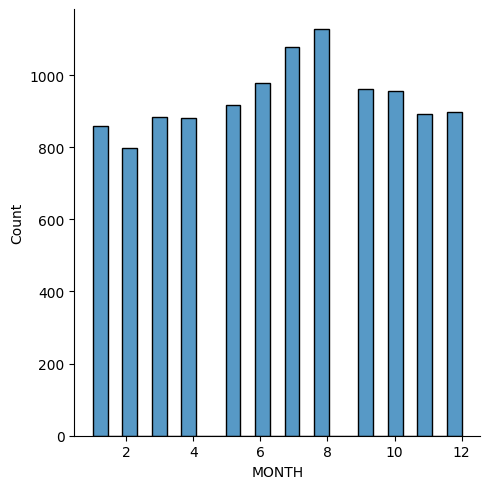

In [35]:
sns.displot(flight_data.MONTH)

<Axes: xlabel='CRS_ARR_TIME', ylabel='ARR_DEL15'>

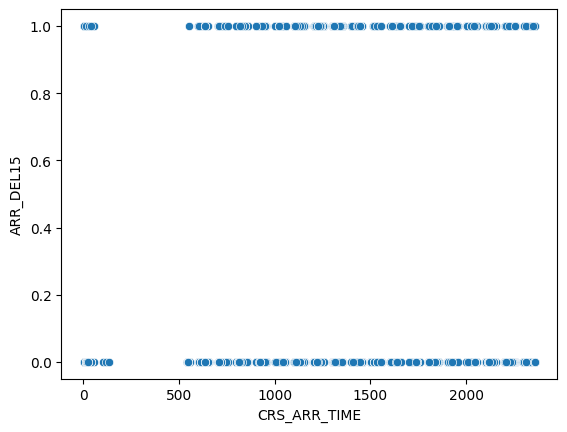

In [36]:
sns.scatterplot(x='CRS_ARR_TIME',y='ARR_DEL15',data=flight_data)

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


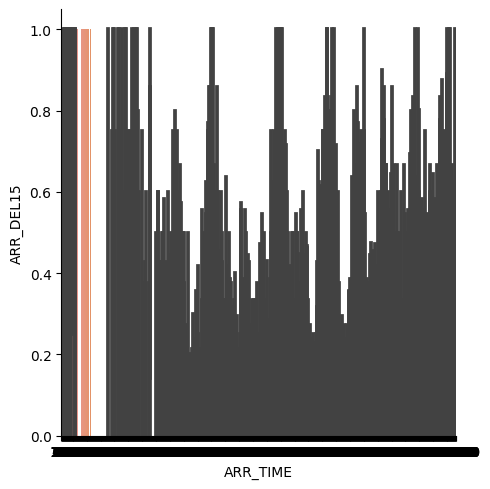

In [37]:
sns.catplot(x="ARR_TIME",y="ARR_DEL15",kind='bar',data=flight_data)

<Axes: >

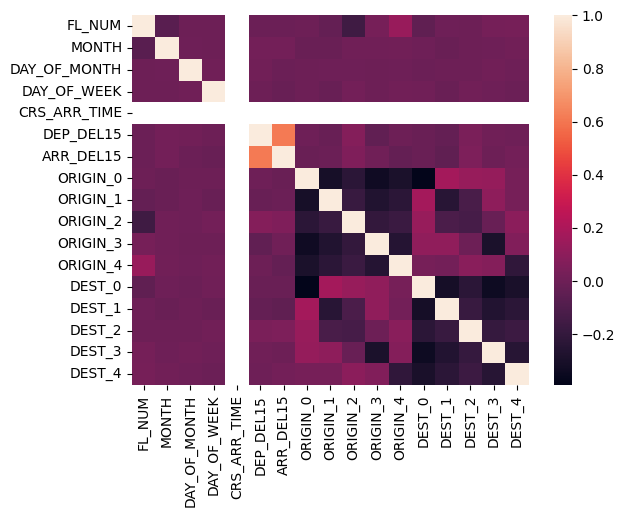

In [43]:
sns.heatmap(dataset.corr())

In [44]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [140]:
x=np.delete(x,[4,5],axis=1)

In [141]:
x.shape

(11231, 7)

In [47]:
x=np.concatenate((t,z,x),axis=1)

In [142]:
x.shape

(11231, 7)

In [143]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [144]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(dataset.drop('ARR_DEL15', axis=1), dataset['ARR_DEL15'], test_size=0.2, random_state=0)


In [145]:
x_test.shape

(2247, 7)

In [146]:
x_train.shape

(8984, 7)

In [ ]:
y_test.shape

(1486, 1)

In [147]:
y_train.shape

(8984, 1)

In [148]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [149]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [56]:
decisiontree = classifier.predict(x_test)

In [150]:
decisiontree

array([1, 0, 0, ..., 1, 0, 0], dtype=uint8)

In [151]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [152]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy')

In [153]:
rfc.fit(x_train,y_train)

<ipython-input-153-b87bb2ba9825>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [154]:
y_predict = rfc.predict(x_test)

In [155]:
# Importing the keras libraries and packages
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [156]:
# Creating ANN sklearn view
classification = Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))





In [64]:
# Compiling the ANN model
classification.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [65]:
# Training the model
classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=10)

Epoch 1/10
1797/1797 [==============================] - 8s 3ms/step - loss: 0.4324 - accuracy: 0.8026 - val_loss: 0.4158 - val_accuracy: 0.8125
Epoch 2/10
1797/1797 [==============================] - 5s 3ms/step - loss: 0.4233 - accuracy: 0.8026 - val_loss: 0.4118 - val_accuracy: 0.8125
Epoch 3/10
1797/1797 [==============================] - 5s 3ms/step - loss: 0.4202 - accuracy: 0.8026 - val_loss: 0.4112 - val_accuracy: 0.8125
Epoch 4/10
1797/1797 [==============================] - 5s 3ms/step - loss: 0.4186 - accuracy: 0.8026 - val_loss: 0.4102 - val_accuracy: 0.8125
Epoch 5/10
1797/1797 [==============================] - 5s 3ms/step - loss: 0.4181 - accuracy: 0.8026 - val_loss: 0.4091 - val_accuracy: 0.8125
Epoch 6/10
1797/1797 [==============================] - 6s 3ms/step - loss: 0.4177 - accuracy: 0.8026 - val_loss: 0.4123 - val_accuracy: 0.8125
Epoch 7/10
1797/1797 [==============================] - 5s 3ms/step - loss: 0.4164 - accuracy: 0.8026 - val_loss: 0.4102 - val_accuracy:

In [ ]:
## Decision tree
y_pred = classifier.predict([[129,99,1,0,0,1,1,1,1]])

print(y_pred)
(y_pred)

In [ ]:
## RandomForest
y_pred = rfc.predict([[129,99,1,0,1,1,1,1,]])

print(y_pred)
(y_pred)

In [159]:
classification.save('flight.h5')

ValueError: ignored

In [78]:
# Testing the model
y_pred = classification.predict(x_test)

71/71 [==============================] - 0s 1ms/step


In [79]:
y_pred

array([[1.75596446e-01],
       [1.00734696e-01],
       [5.44585305e-07],
       ...,
       [2.58372009e-01],
       [2.24402569e-07],
       [3.30196410e-01]], dtype=float32)

In [80]:
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [81]:
def predict_exit(sample_value):
  # Convert list to numpy array
  sample_value = np.array(sample_value)
  # Reshape because sample_value contains only 1 record
  sample_value = sample_value.reshape(1, -1)
  # Feature Scaling
  sample_value = sc.transform(sample_value)
  return classifier.predict(sample_value) 

In [ ]:
test=classification.predict([[1,1,121.000000,36.0,0,0,1,0,1,1,1,1,1,1,1,1]])
if test==1:
    print('prediction: Chance of delay')
else:
    print('prediction: No chance of delay.')

In [85]:
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

In [98]:
def fun():
  dfs= []
  models =[
          ('RFC', RandomForestClassifier()),
          ('DecisionTree',DecisionTreeClassifier()),
          ('ANN',MLPClassifier())
         ]
  results = []
  names = []
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ['no delay','delay']
  for name,model in models:
        kfold = model_selection.kFold(n_splits=5, shuffle=true, random_state=90210)
        cv_results = model_selection.cross_validate(model, x_train, y_train, cv_ffold, scoring=scoring)
        clf = model.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print(name)
        print(classification_report(y_test, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this.df)
  final = pd.concat(dfs, ignore_index=True)
  return final                  
      

In [103]:
# randomforest accuracy
#print('Training accuracy: ',accuracy_score(y_train,y_test))
#print('Training accuracy: ',accuracy_score(y_train,y_predict))

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_test)
cm

In [108]:
# Accuracy score of desicionTree
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [109]:
desacc

0.9848687138406764

In [110]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,decisiontree)

In [90]:
cm

array([[1786,   16],
       [  18,  427]])

In [111]:
# Calculate the Accuracy of ANN 
from sklearn.metrics import accuracy_score,classification_report
score = accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is: {}%'.format(score*100))

The accuracy for ANN model is: 80.19581664441478%


In [113]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm


array([[1802,    0],
       [ 445,    0]])

In [116]:
# giving some parameters that can be used in randized search cv
parameters = {
    'n_estimators' : [1,20,30,55,68,74,90,120,115],
    'criterion':['gini','entropy'],
    'max_features' : ["auto", "sqrt", "log2"],
    'max_depth' : [2,5,8,10], 'verbose' : [1,2,3,4,6,8,9,10]
}
    

In [162]:
#performing the randomized cv
RFC = RandomizedSearchCV(estimator=rfc,param_distributions=parameters,cv=10,n_iter=4)

In [164]:
RFC.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115


[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s


building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s



building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building t

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s



building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building t

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s


building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s


building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s


building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s



building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 6

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s


building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s



building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 6

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 o

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurre

building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 4

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | 

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 4

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tr

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tree 1 of 1
building tree 1 of 1
building tree 1 of 1
building tree 1 of 1
building tree 1 of 1
building tree 1 of 1


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 12

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 74 of 74
building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [ ]:
#getting the best paarmets from the giving list and best score from them
bt_params = RCV.best_params_
bt_score = RCV.best_score_

In [ ]:
bt_params

{'verbose': 9,
 'n_estimators': 55,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [ ]:
bt_score

0.8191919191919192

In [ ]:
model = RandomForestClassifier(verbose= 10, n_estimators= 120, max_features= 'log2',max_depth= 10,criterion= 'entropy')
RCV.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68
building tree 1 of 68


[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68
building tree 1 of 68
building tree 2 of 68
building tree 3 of 68


[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 o

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClass

building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [ ]:
y_predict_rf = RCV.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished


In [ ]:
RFC=accuracy_score(y_test,y_predict_rf)
RFC

0.8411843876177658

In [ ]:
import pickle
pickle.dump(RCV,open('flight.pkl','wb'))